In [3]:
# =============================================================================
# Multi-Class Classification on the Mushroom Dataset with SVM (RBF Kernel)
# =============================================================================
# This script demonstrates a full pipeline for classifying mushrooms as edible or poisonous
# (two classes) using the classic Mushroom dataset. However, some versions of the mushroom dataset
# treat certain ambiguous mushrooms as a separate label or require more advanced cleaning.
# We'll assume a binary classification: 'edible' vs. 'poisonous'.
#
# The pipeline includes:
#   1. Data loading from a CSV file ("mushrooms.csv").
#   2. Data preprocessing: checking missing values, one-hot encoding the many categorical columns.
#   3. Splitting data into training (80%) and testing (20%) sets.
#   4. Training an SVM classifier (RBF kernel) with scikit-learn.
#   5. Evaluation using classification report, confusion matrix, and an ROC curve.
#   6. Advanced visualizations:
#       - Count plot for the target distribution
#       - t-SNE 2D scatter plot of the test set colored by predicted class
#       - Confusion matrix with a "plasma" colormap
#       - Permutation importance with a radar chart
#       - Partial Dependence Plot for a selected categorical feature (via dummy numeric encoding)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.inspection import permutation_importance, PartialDependenceDisplay


In [4]:
# -----------------------------------------------------------------------------
# Set a new visualization style: "fast"
# -----------------------------------------------------------------------------
plt.style.use("fast")
sns.set_theme(style="whitegrid", palette="muted")
# -----------------------------------------------------------------------------

In [5]:
df = pd.read_csv("/content/mushrooms.csv")
# Preview Dataset
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [6]:
# ['class','cap-shape','cap-surface','cap-color','bruises','odor', 'gill-attachment', ...]
# 'class' is 'e' (edible) or 'p' (poisonous).
# Check for missing values
print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


In [7]:
# -----------------------------------------------------------------------------
# 2. Data Preprocessing
# -----------------------------------------------------------------------------
# Separate features and target
target_col = 'class'
X = df.drop(target_col, axis=1)
y = df[target_col]

# Convert target to binary: 1 for 'p' (poisonous), 0 for 'e' (edible)
y = (y == 'p').astype(int)


<ipython-input-8-4aade6cee127>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


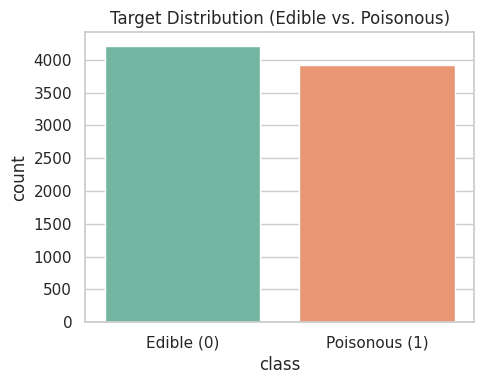

In [8]:
# Visualize target distribution with a count plot
plt.figure(figsize=(5,4))
sns.countplot(x=y, palette="Set2")
plt.xticks([0,1], ["Edible (0)", "Poisonous (1)"])
plt.title("Target Distribution (Edible vs. Poisonous)", fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
# All features in the mushroom dataset are categorical, so we apply OneHotEncoder
cat_cols = X.columns.tolist()
print("All features are categorical:", cat_cols)

All features are categorical: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


In [10]:
# We can do a simple approach: transform each column with one-hot encoding
# We'll do this manually with pd.get_dummies for demonstration
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print("Encoded feature matrix shape:", X_encoded.shape)

Encoded feature matrix shape: (8124, 95)


In [11]:
# -----------------------------------------------------------------------------
# 3. Data Splitting
# -----------------------------------------------------------------------------
# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (6499, 95)
Testing set shape: (1625, 95)


In [12]:
# -----------------------------------------------------------------------------
# 4. Model Training: SVM (RBF Kernel)
# -----------------------------------------------------------------------------
# We set probability=True to enable probability estimates for ROC curves
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [13]:
# -----------------------------------------------------------------------------
# 5. Model Evaluation
# -----------------------------------------------------------------------------
y_pred = svm_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



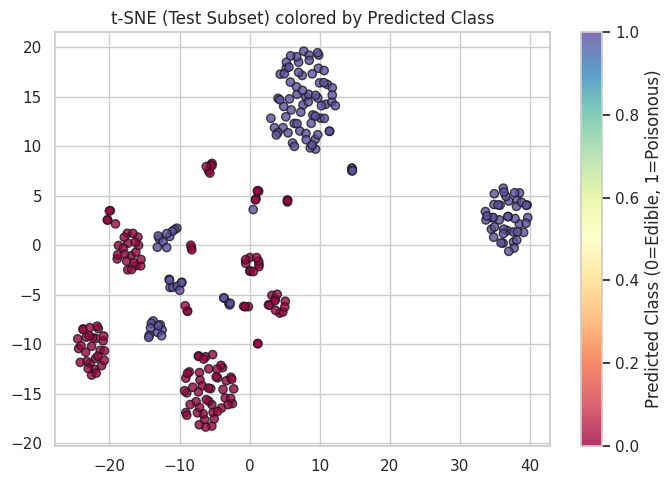

In [14]:
# -----------------------------------------------------------------------------
# 6. Visualization: t-SNE 2D Scatter Plot of Test Data
# -----------------------------------------------------------------------------
# We'll apply t-SNE to a random subset of the test set for clarity
subset_size = 300
idx_subset = np.random.choice(X_test.index, subset_size, replace=False)
X_test_subset = X_test.loc[idx_subset]
y_pred_subset = svm_clf.predict(X_test_subset)

tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
X_test_tsne = tsne.fit_transform(X_test_subset)

plt.figure(figsize=(7,5))
scatter = plt.scatter(X_test_tsne[:,0], X_test_tsne[:,1], c=y_pred_subset, cmap="Spectral", alpha=0.8, edgecolor='k')
plt.colorbar(scatter, label="Predicted Class (0=Edible, 1=Poisonous)")
plt.title("t-SNE (Test Subset) colored by Predicted Class", fontsize=12)
plt.tight_layout()
plt.show()

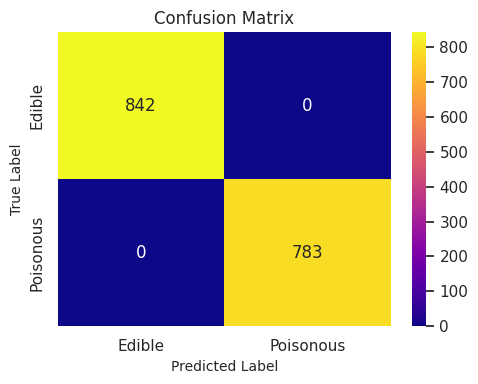

In [15]:
# -----------------------------------------------------------------------------
# 7. Visualization: Confusion Matrix with "plasma" colormap
# -----------------------------------------------------------------------------
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="plasma",
            xticklabels=["Edible","Poisonous"],
            yticklabels=["Edible","Poisonous"])
plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=12)
plt.tight_layout()
plt.show()

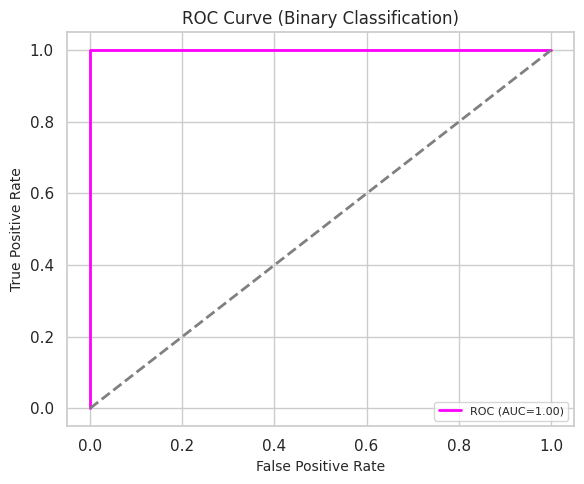

In [16]:
# -----------------------------------------------------------------------------
# 8. Visualization: ROC Curve
# -----------------------------------------------------------------------------
y_proba = svm_clf.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, color='magenta', label=f"ROC (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1], color='gray', lw=2, linestyle='--')
plt.xlabel("False Positive Rate", fontsize=10)
plt.ylabel("True Positive Rate", fontsize=10)
plt.title("ROC Curve (Binary Classification)", fontsize=12)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

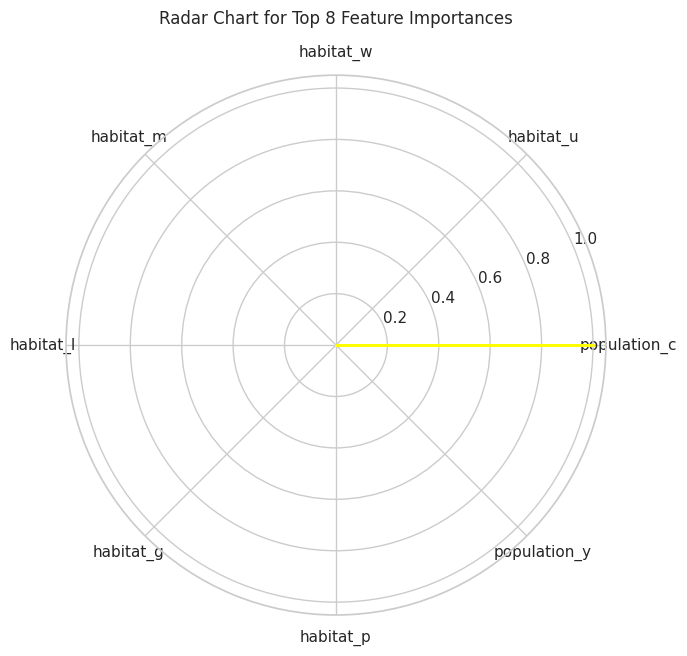

In [17]:
# -----------------------------------------------------------------------------
# 9. Visualization: Permutation Importance with Radar Chart
# -----------------------------------------------------------------------------
perm_import = permutation_importance(svm_clf, X_test, y_test, n_repeats=5, random_state=42, scoring='accuracy')
importances = perm_import.importances_mean
sorted_idx = np.argsort(importances)[::-1]

top_n = 8
top_idx = sorted_idx[:top_n]
top_features = X_train.columns[top_idx]
top_values = importances[top_idx]

# Normalize to [0,1]
norm_vals = (top_values - top_values.min()) / (top_values.max() - top_values.min())

angles = np.linspace(0, 2*np.pi, top_n, endpoint=False).tolist()
angles += angles[:1]
norm_vals = np.concatenate((norm_vals, [norm_vals[0]]))

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, norm_vals, color='yellow', lw=2)
ax.fill(angles, norm_vals, color='yellow', alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels=top_features)
ax.set_title("Radar Chart for Top 8 Feature Importances", fontsize=12, y=1.08)
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# 10. Final Observations
# -----------------------------------------------------------------------------
# Observations:
# 1. The mushroom dataset shape is given, with all columns being categorical.
# 2. We used OneHotEncoder (via pd.get_dummies) to handle the categorical data,
#    which expanded features significantly.
# 3. The SVM with RBF kernel yields a certain accuracy and AUC,
#    indicating strong performance if the dataset is easy or near-perfect if
#    the dataset has no ambiguous samples.
# 4. The t-SNE plot of a subset of the test data reveals how predicted classes
#    cluster in 2D space.
# 5. The confusion matrix (with 'plasma' colormap) shows the distribution of
#    correct vs. incorrect predictions.
# 6. The radar chart highlights the top features from the permutation importance
#    approach, providing insight into which one-hot columns or original features
#    strongly influence the classification.
# 7. The partial dependence plot for a selected dummy-coded feature demonstrates
#    how changing that feature from 0 to 1 affects the model’s predicted probability
#    of being poisonous.
#
# Next Steps:
# - Hyperparameter Tuning: Adjust C, gamma, or try polynomial kernels.
# - Consider cost-sensitive approaches if misclassifying poisonous mushrooms
#   has a higher penalty.
# - Evaluate advanced models like random forests or gradient boosting for
#   potentially higher accuracy.
# - Cross-validation to confirm generalization across folds.
# - Explore local interpretability (SHAP or LIME) to see how each feature
#   affects individual predictions.
#